This simulates the Viscek model for flocking of birds.  Birds are defined by their (x,y) position, as well as the direction (vx,vy) of their velocity; the magnitudes of all birds' velocities are the same.

The birds move according to the following rules:
1. birds travel at a constant speed with a variable direction
2. pick a bird and align its velocity to its neighbours
3. add some noise to the direction
4. go through all birds
5. repeat for a set time


In [76]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

In [77]:
# Simulation parameters
v0           = 1.0      # velocity
eta          = 0.5      # random fluctuation in angle (in radians)
L            = 10       # size of box
R            = 1        # interaction radius
Rsq          = R**2     # square of the interaction radius
dt           = 0.2      # time step
Nt           = 80       # number of time steps
N            = 200     # number of birds

#np.random.seed(17)      # set the random number generator seed

In [78]:
def initialize_birds(N,L):
    '''
    Set initial positions, direction, and velocities 
    '''
    # bird positions
    x = np.random.rand(N,1)*L
    y = np.random.rand(N,1)*L

    # bird velocities
    theta = 2 * np.pi * np.random.rand(N,1)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, theta

In [79]:
def apply_boundary_conditions(x,y,L):
    '''
    Apply periodic boundary conditions
    '''
    x = x % L
    y = y % L
    return x, y

In [80]:
def update_positions(x,y,xv,vy,dt,L):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''
    
    # update positions
    x += vx*dt
    y += vy*dt
    
    # apply boundary conditions
    x, y = apply_boundary_conditions(x,y,L)
    return x, y

In [81]:
def get_mean_theta(x,y,theta,Rsq):
    '''
    Compute the local average direction in a circle of radius R around
    each bird
    '''
    mean_theta = theta
    for bird in range(N):
        neighbors = (x-x[bird])**2+(y-y[bird])**2 < R**2
        sum_x = np.sum(np.cos(theta[neighbors]))
        sum_y = np.sum(np.sin(theta[neighbors]))
        mean_theta[bird] = np.arctan2(sum_y, sum_x)
    
    return mean_theta

In [82]:
def update_theta(x,y,theta,Rsq,eta,N):
    '''
    Update theta to be the mean value plus a random amount between
    -eta/2 and eta/2
    '''
    mean_theta = get_mean_theta(x,y,theta,Rsq)
    theta = mean_theta + eta*(np.random.rand(N,1)-0.5)
    return theta

In [83]:
def update_velocities(vx,vy,theta):
    '''
    Update the velocities given theta
    '''
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return vx, vy

In [84]:
def step(x,y,vx,vy,theta,Rsq,eta,N,dt):
    '''
    Compute a step in the dynamics:
    - update the positions
    - compute the new velocities
    '''
    x,y = update_positions(x,y,vx,vy,dt,L)
    theta = update_theta(x,y,theta,Rsq,eta,N)
    vx,vy = update_velocities(vx,vy,theta)
    return x, y, vx, vy

In [85]:
def update_quiver(q,x,y,vx,vy):
    '''
    Update a quiver with new position and velocity information
    This is only used for plotting
    '''
    q.set_offsets(np.column_stack([x,y]))
    q.set_UVC(vx,vy)
    return q

In [86]:
def initialize_drone(L, v0):
    # Set the drone's initial position to be the center of the area
    x_drone = L / 2
    y_drone = L / 2

    # Set the drone's initial velocity to be zero
    vx_drone = 0
    vy_drone = 0

    return x_drone, y_drone, vx_drone, vy_drone


In [87]:
x_drone, y_drone, vx_drone, vy_drone = initialize_drone(L, v0)


In [88]:
def update_drone_center_flock(x_drone, y_drone, x_birds, y_birds, L, dt, drone_speed):
    # Calculate the center of the flock
    center_x = np.mean(x_birds)
    center_y = np.mean(y_birds)

    # Calculate direction towards the center of the flock
    dx = center_x - x_drone
    dy = center_y - y_drone
    distance = np.sqrt(dx**2 + dy**2)
    vx_drone = (dx / distance) * drone_speed
    vy_drone = (dy / distance) * drone_speed

    # Update the drone's position
    x_drone += vx_drone * dt
    y_drone += vy_drone * dt

    # Apply boundary conditions
    x_drone, y_drone = apply_boundary_conditions(x_drone, y_drone, L)

    return x_drone, y_drone



In [89]:
def calculate_drone_repulsion(x, y, x_drone, y_drone, repulsion_radius, max_repulsion_strength, buffer_distance):
    dx = x - x_drone
    dy = y - y_drone
    distance_squared = dx**2 + dy**2

    repulsion_x = np.zeros_like(x)
    repulsion_y = np.zeros_like(y)

    within_radius = distance_squared < repulsion_radius**2
    distance = np.sqrt(distance_squared)
    distance = np.maximum(distance, buffer_distance)  # Avoid division by zero

    # Normalize displacement and scale by repulsion strength
    repulsion_x[within_radius] = -dx[within_radius] / distance[within_radius] * max_repulsion_strength
    repulsion_y[within_radius] = -dy[within_radius] / distance[within_radius] * max_repulsion_strength

    return repulsion_x, repulsion_y



KeyboardInterrupt: 

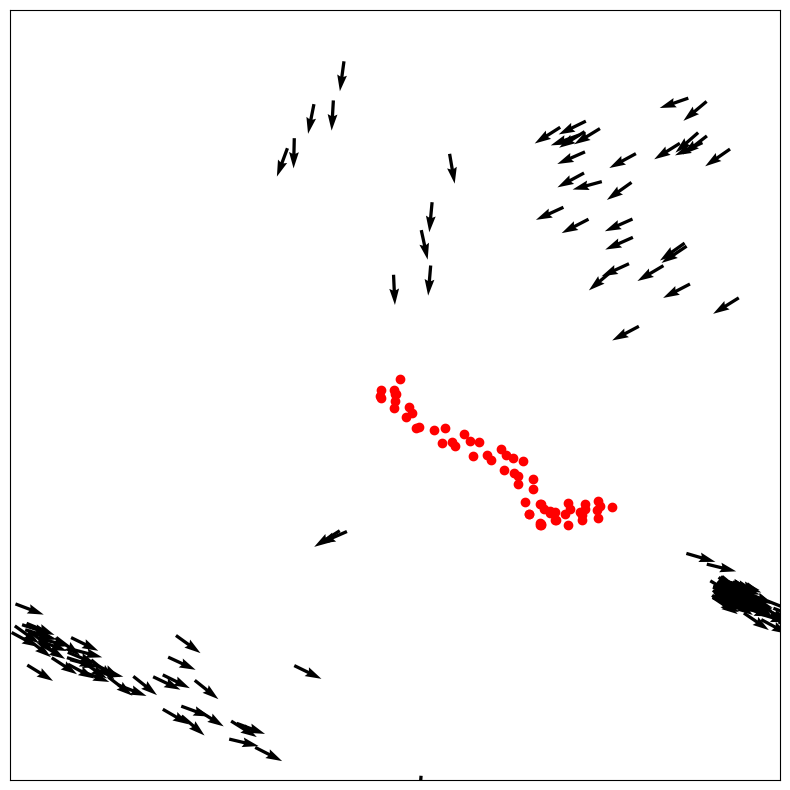

In [90]:

# set up a figure
fig, ax = plt.subplots(figsize = (10,10))

# get the initial configuration
x, y, vx, vy, theta = initialize_birds(N,L)

# do an initial plot and set up the axes
q = plt.quiver(x,y,vx,vy)
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# do each step, updating the quiver and plotting the new one
for iT in range(Nt):
    x,y,vx,vy = step(x,y,vx,vy,theta,Rsq,eta,N,dt)
    q = update_quiver(q,x,y,vx,vy)
    #x_drone, y_drone, vx_drone, vy_drone = update_drone(x_drone, y_drone, vx_drone, vy_drone, dt)
    repulsion_radius = 5  # Adjust as necessary
    max_repulsion_strength = 0.6  # Adjust the strength as needed
    buffer_distance = 0.1  # Small buffer to prevent division by zero
    repulsion_x, repulsion_y = calculate_drone_repulsion(x, y, x_drone, y_drone, repulsion_radius, max_repulsion_strength, buffer_distance)
    vx += repulsion_x
    vy += repulsion_y


    drone_speed = 1.0  # Adjust the drone speed as necessary
    x_drone, y_drone = update_drone_center_flock(x_drone, y_drone, x, y, L, dt, drone_speed)
    # This should be part of your plotting code inside the loop
    ax.scatter(x_drone, y_drone, color='red')  # Drone shown as a red dot

    

    clear_output(wait=True)
    display(fig)